In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
import os
import pickle
from torchvision import datasets, transforms


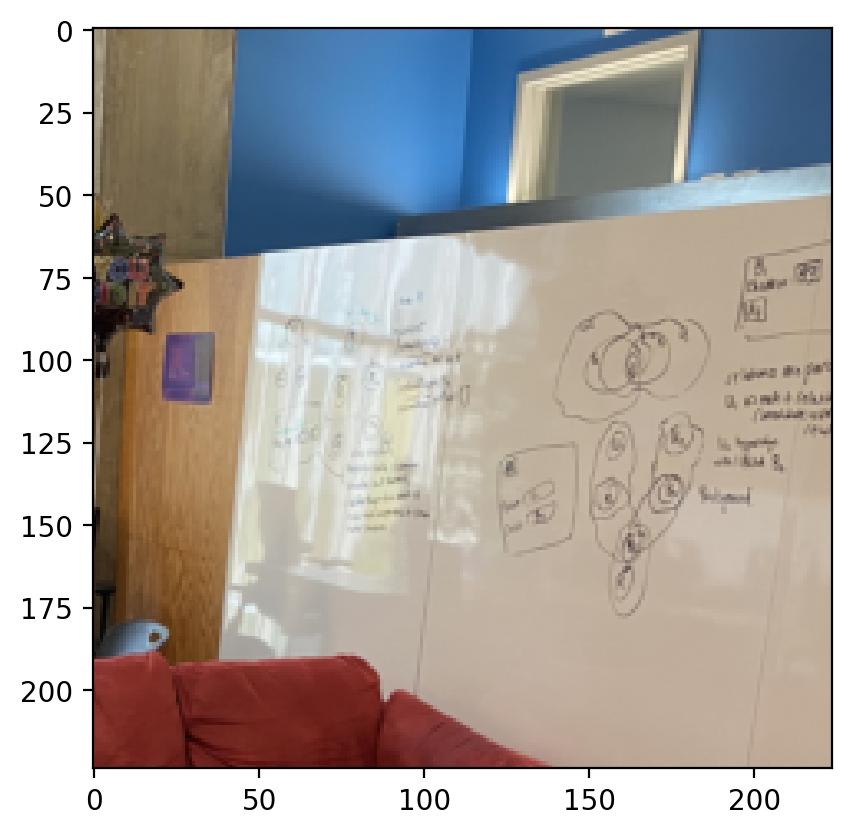

In [177]:
TRAIN_PATH = 'split_dataset/train'
def get_transform():
    return transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
def get_augmented_data_loader(augmented_transform):
    return datasets.ImageFolder(TRAIN_PATH, transform=augmented_transform)
random_crop = transforms.Compose([transforms.RandomCrop(1500), transforms.Resize((224, 224)), transforms.ToTensor()])
train_set = get_augmented_data_loader(random_crop)
plt.imshow(train_set[4][0].permute(1, 2, 0))

In [53]:
def load_model(name):
    model_path = os.path.join('results', f'{name}.model')
    hist_path = os.path.join('results', f'{name}.hist')
    model = torch.load(model_path)
    with open(hist_path, 'rb') as f:
        hist = pickle.load(f)
    return model, hist


def plot_hist(hists, names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.text(0.5, 0.04, 'Epoch', ha='center')
    ax1.set_title('Training Loss')
    ax1.set_ylabel('Loss')
    ax2.set_title('Validation Top1 Accuracy')
    ax2.set_ylabel('Accuracy %')
    xs = range(1, len(hists[0][0]) + 1)
    ax1.set_xticks(xs)
    ax2.set_xticks(xs)
    for i in range(len(hists)):
        ax1.plot(xs, hists[i][0], label=names[i])
        ax2.plot(xs, hists[i][1], label=names[i])
        print(f'{names[i]} final accuracy: {hists[i][1][-1]}')
    ax1.legend()
    ax2.legend()

baseline final accuracy: 80.0
all_layers final accuracy: 100.0
last_layer final accuracy: 90.0
data_augmentation final accuracy: 10.0


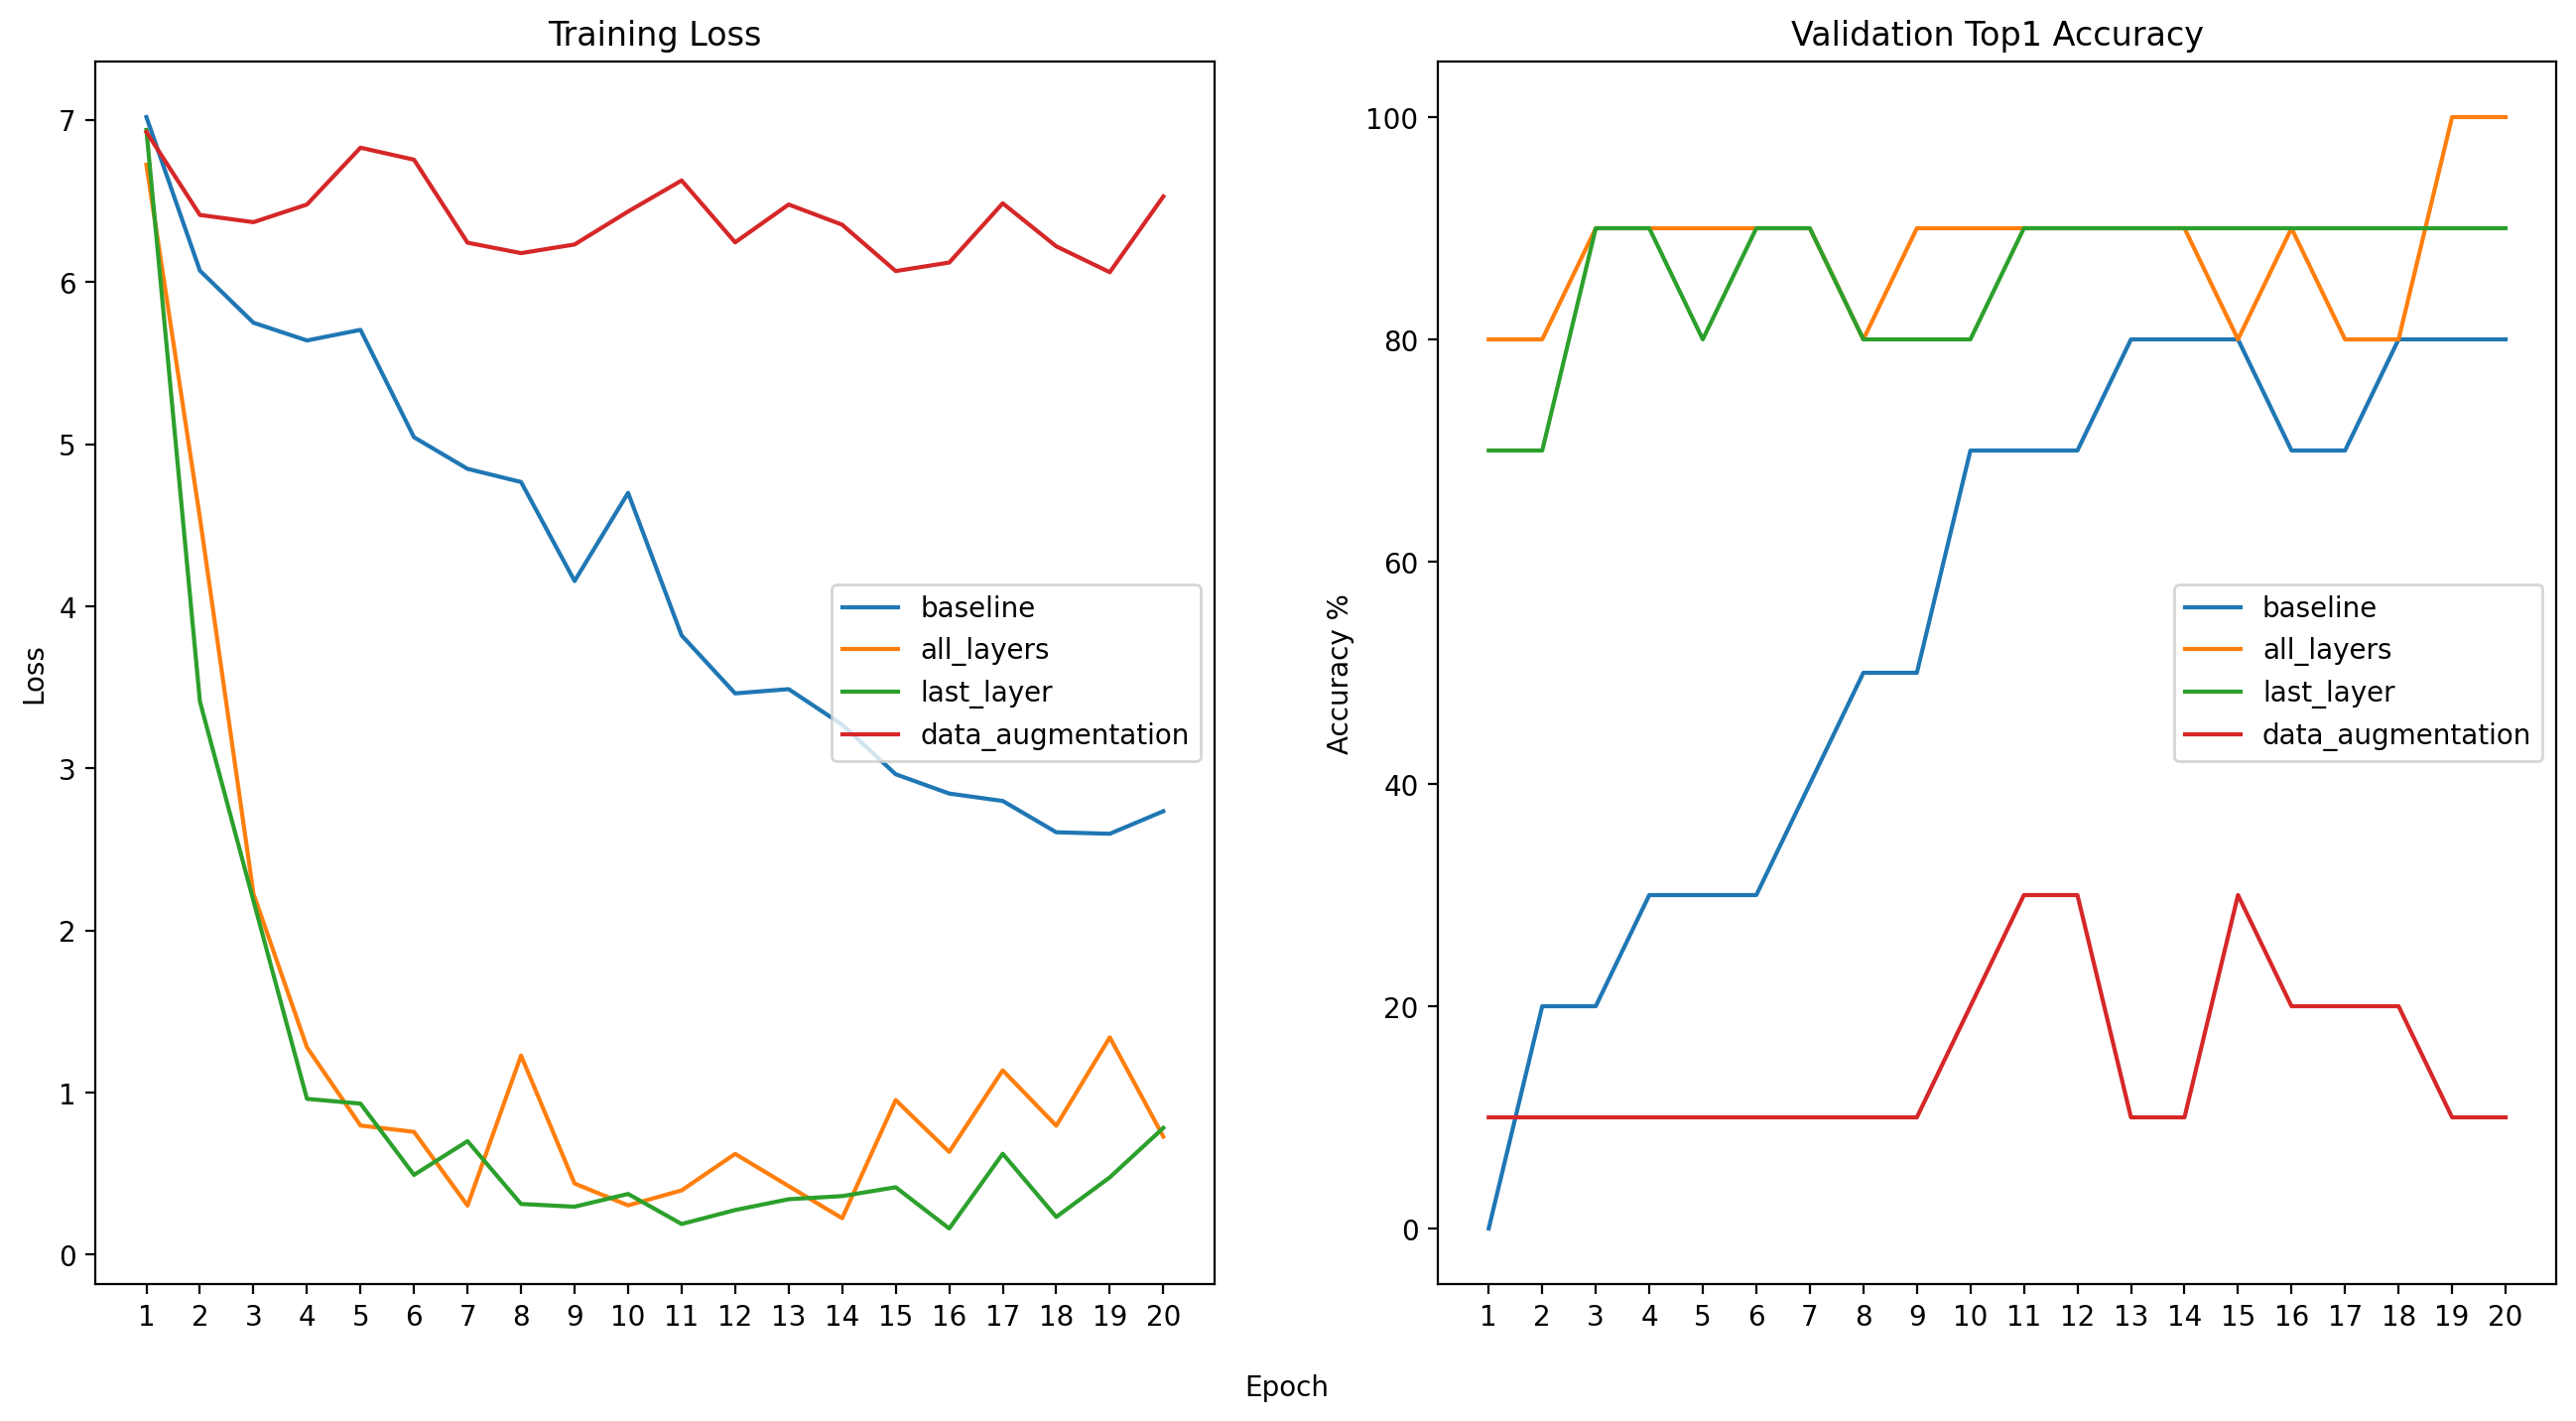

In [54]:
baseline_model, baseline_hist = load_model('baseline')
all_model, all_hist = load_model('resnet_all')
last_model, last_hist = load_model('resnet_last_layer')

plot_hist([
    baseline_hist,
    all_hist,
    last_hist,
], [
    'Baseline',
    'All Layers',
    'Last Layer',
])

In [114]:

def visualize_resnet_features(model, image):
    image = image.unsqueeze(0)
    outputs = []
    names = []
    i = 1
    for layer in model.resnet_layers[:4]:
        image = layer(image)
        outputs.append(image)
        names.append(f'layer {i}')
        i += 1
    for seq in model.resnet_layers[4:8]:
        for layer in seq:
            image = layer(image)
            outputs.append(image)
            names.append(f'layer {i}')
            i += 1
    # # print feature_maps
    # for feature_map in outputs:
    #     print(feature_map.shape)

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    # for fm in processed:
    #     print(fm.shape)

    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    # plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

torch.float32

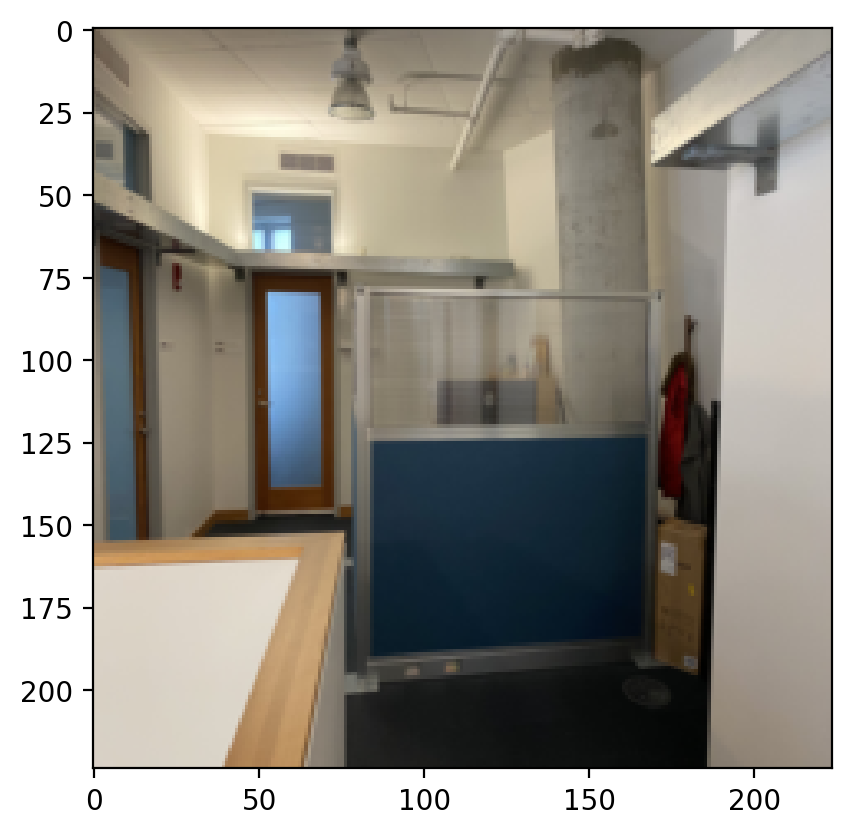

In [117]:
image = val[5][0]
plt.imshow(image.permute(1, 2, 0))
image.dtype

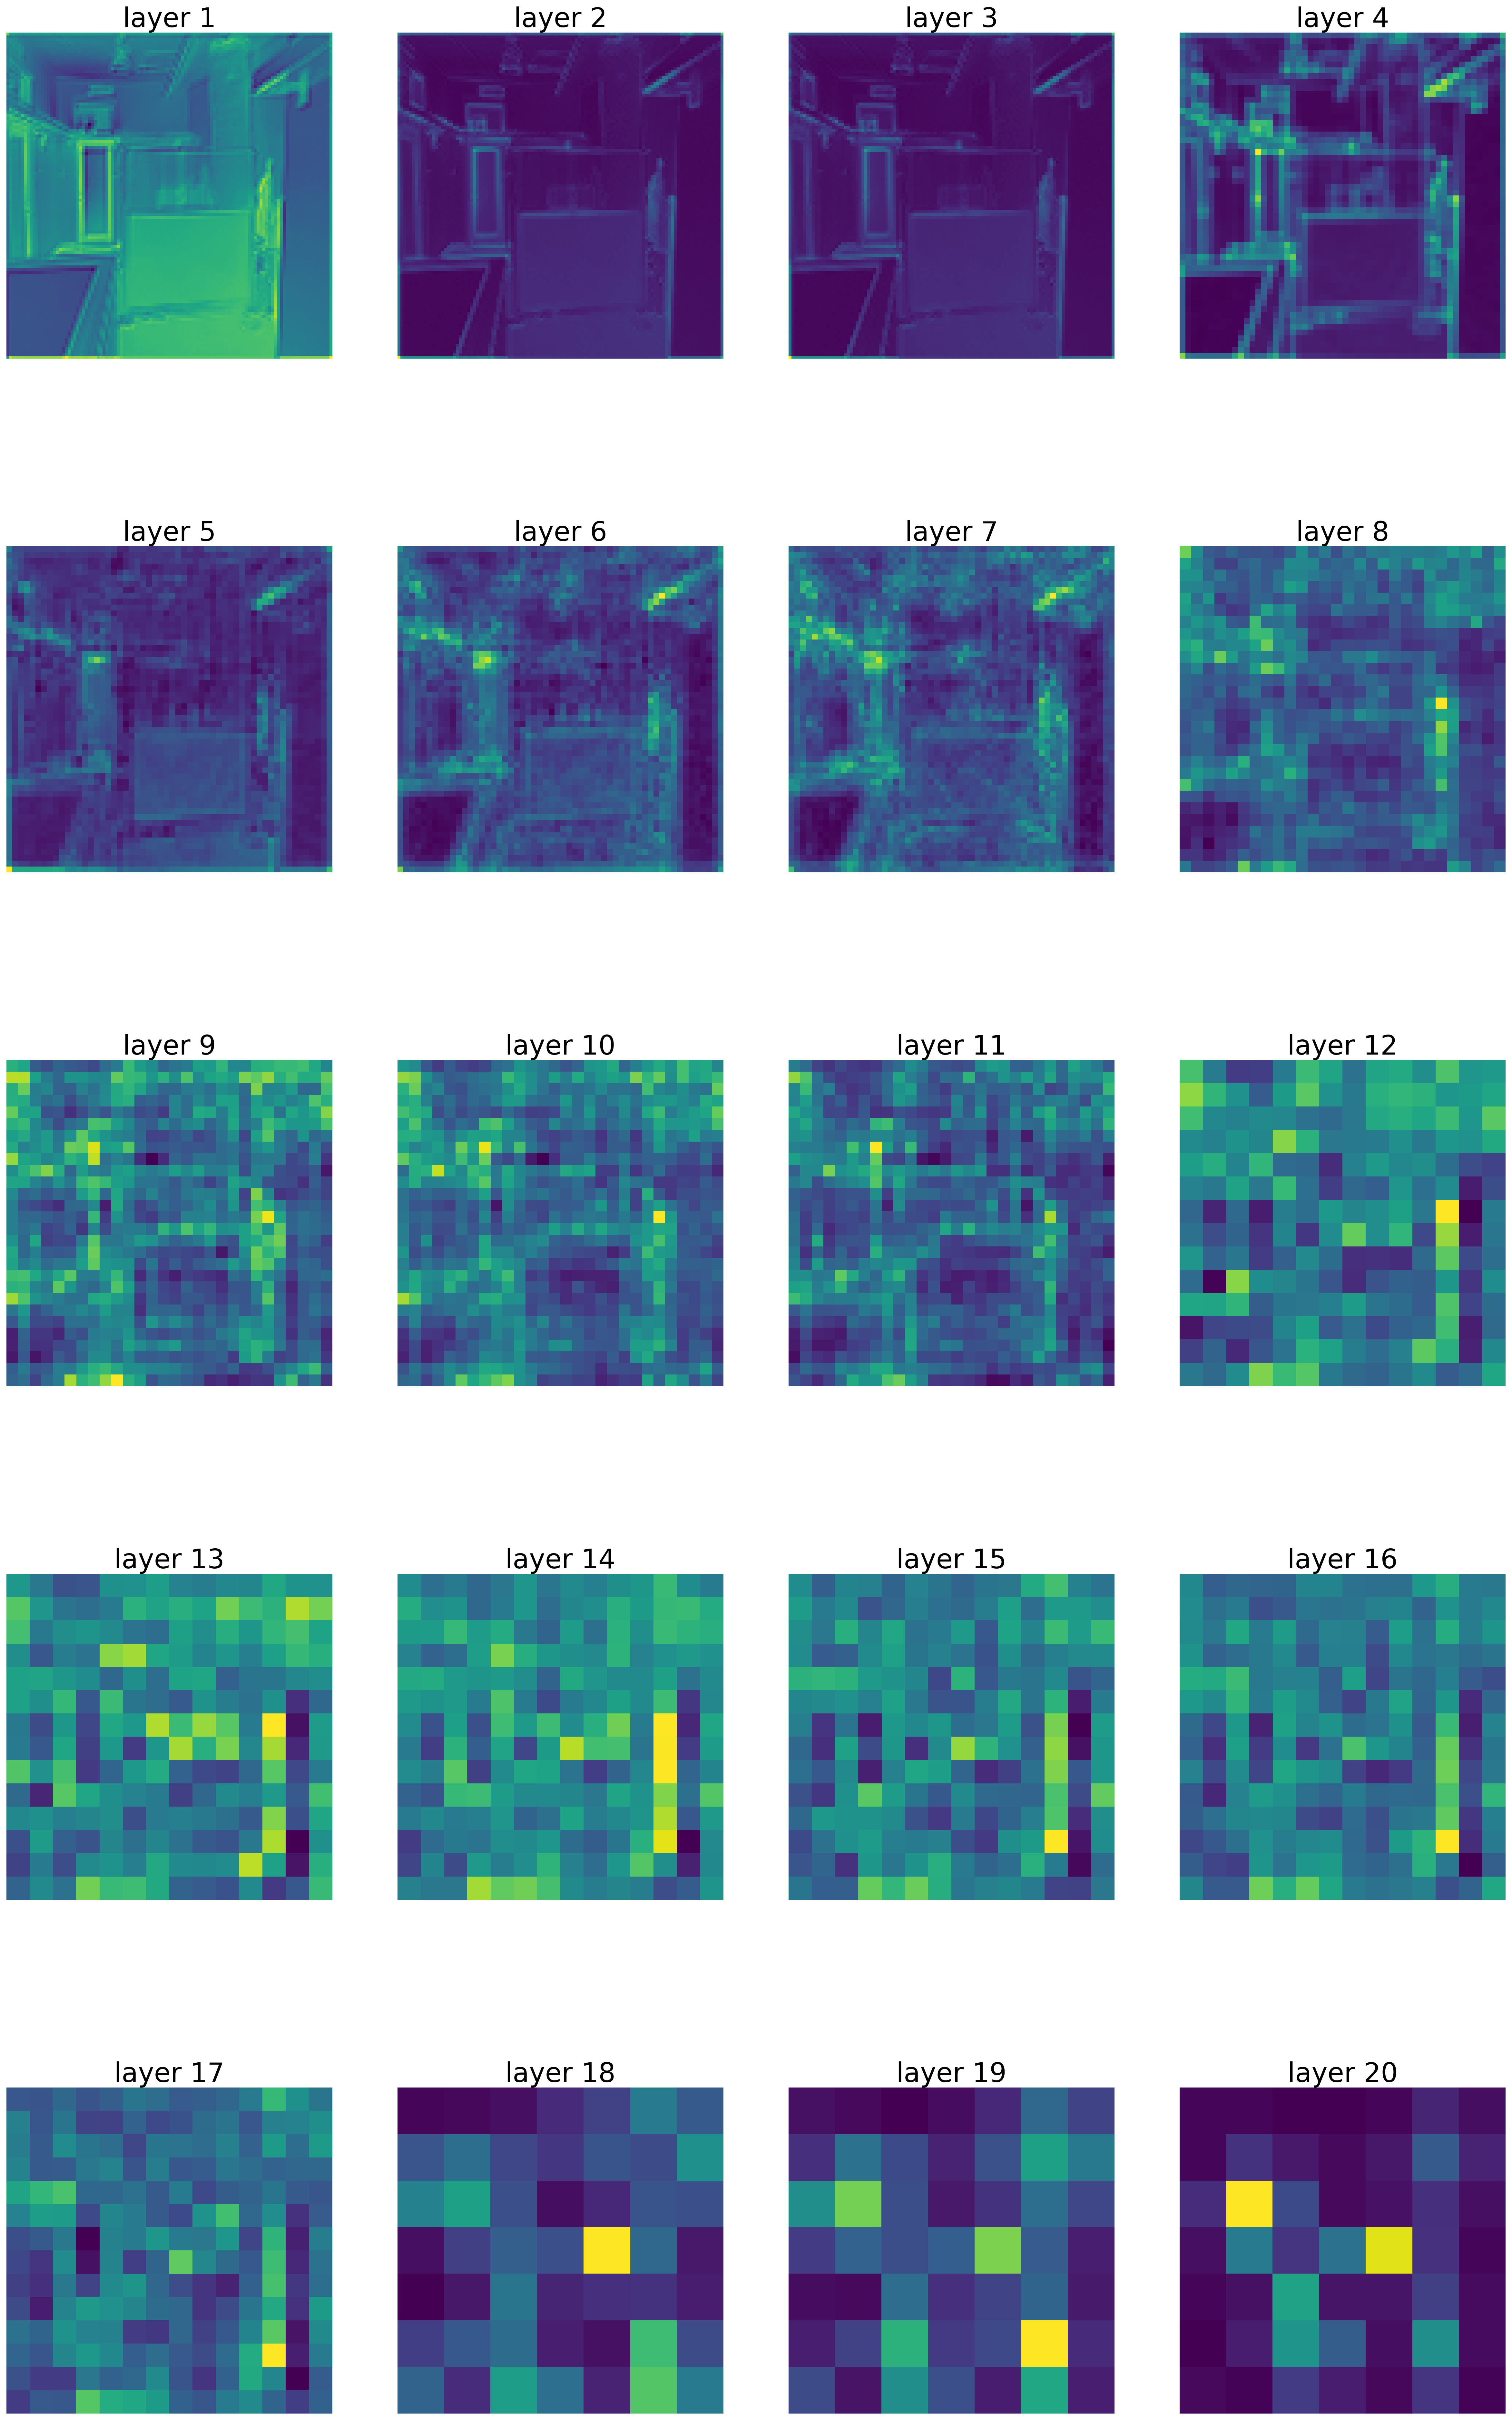

In [118]:
visualize_resnet_features(model, image)

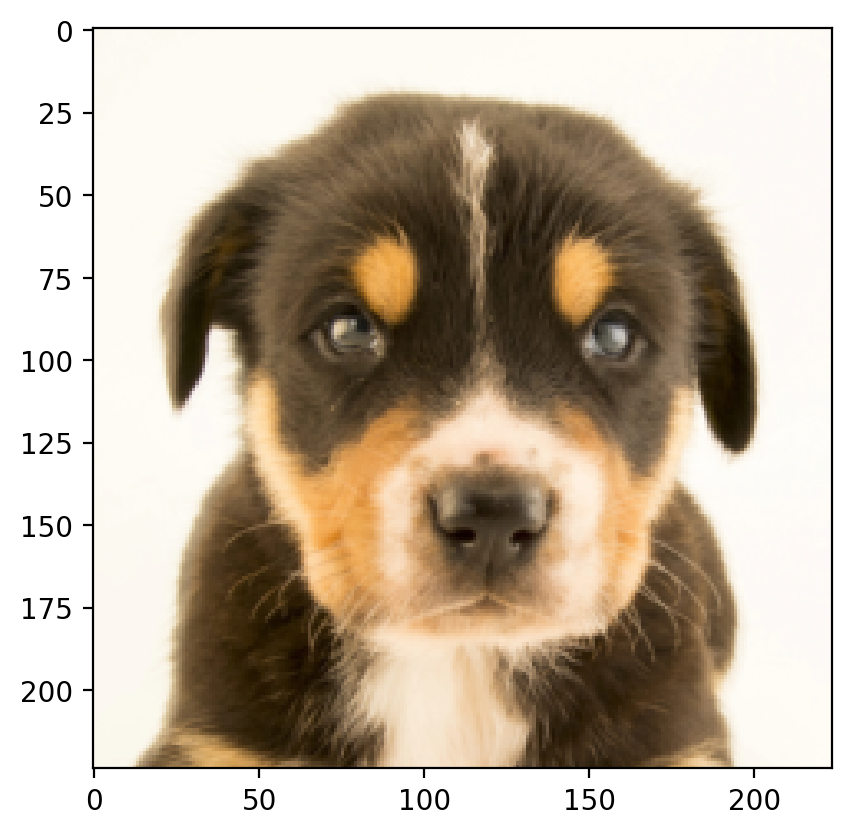

In [131]:
image = transform(PIL.Image.open("dog.jpeg"))
plt.imshow(image.permute(1, 2, 0))

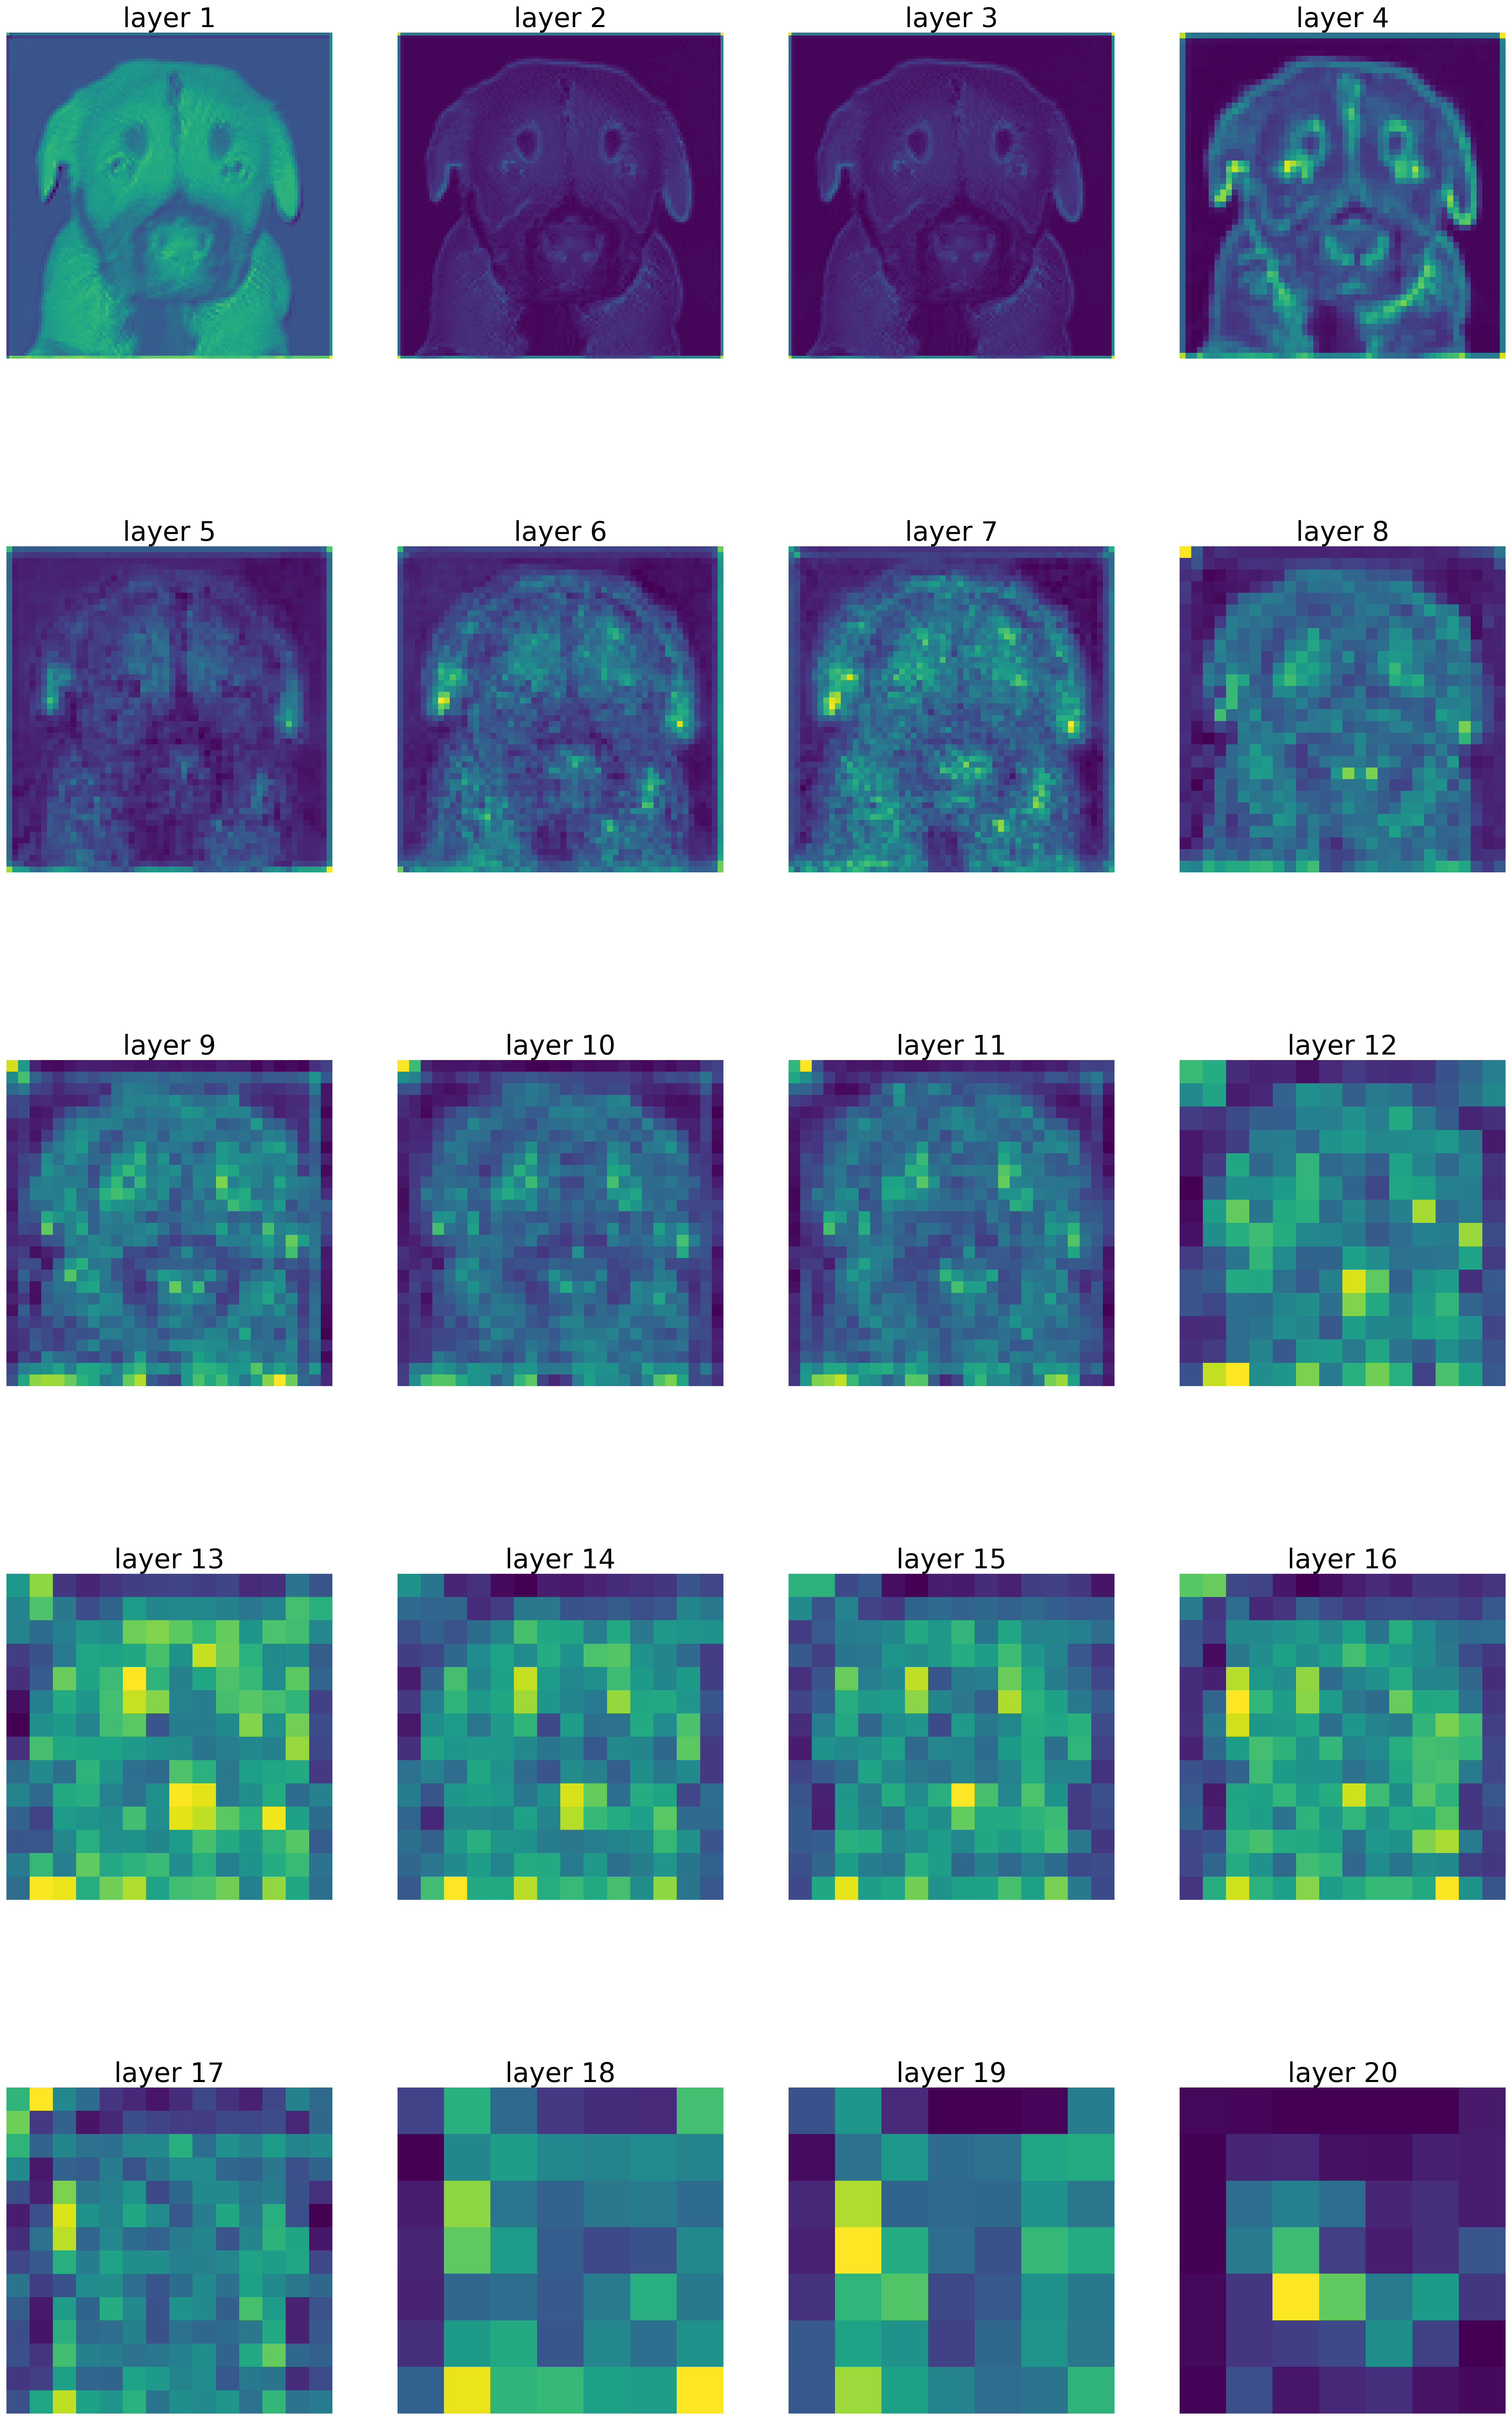

In [132]:
class Original():
    def __init__(self):
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        layers = list(resnet.children())[:-1]
        self.resnet_layers = nn.Sequential(*layers)
        
visualize_resnet_features(Original(), image)